# INF8111 - Fouille de données


## TP2 Automne 2019 - Extraction et analyse d'une base de données de tweets

##### Membres de l'équipe:

    - Amine BELLAHSEN
    - Abderrahim KHALIFA
    - Hamza SGHIR

## Présentation du problème

En 2017, Twitter compte 313 millions d’utilisateurs actifs par mois avec 500 millions de tweets envoyés par jour. Cette information est rendue disponible à destination de la recherche et du développement web grâce à une API publique qui permet de collecter les informations que l'on souhaite.

Néanmoins, la politique de développement de Twitter limite le partage de ces données. En effet, le partage du contenu des tweets dans une base de données n'est pas autorisé, seuls les identifiants des tweets le sont. 
Pour partager publiquement une base de données de tweets que l'on a créée, il faut que cette base de données ne soit consituée que des identifiants de tweets, et c'est ce que l'on retrouve dans la plupart des jeux de données publiques.

Il est donc nécessaire pour exploiter ces données "d'hydrater" les tweets en question, c'est-à-dire extraire l'ensemble des informations à partir de l'ID, ce qui demande d'utiliser l'API de Twitter.

Nous allons ici utiliser des bases de données publiques créées par GWU (George Washington University), qui ont l'avantage d'être très récentes : 
https://dataverse.harvard.edu/dataverse/gwu-libraries

Chaque base de données de GWU couvre un sujet précis (élection américaine de 2016, jeux olympiques, etc.), et les données ont été recueillis en appliquant des requêtes qui filtraient les résultats pour n'avoir que des tweets pertinents. Un fichier README est fourni avec chaque base de données pour donner les détails de création du *dataset*. 


**Les objectifs de ce TP sont donc les suivants :**

 1. Construire un *crawler* qui collecte les informations d'un tweet à partir de son ID, avec le jeu de données de son choix et les informations pertinentes pour le sujet choisi
 2. A partir de ces données de Twitter collectés, application de méthodes en Machine Learning (ML)/Natural Language Processing (NLP) pour fournir une analyse pertinente. 


Twitter autorisant le partage **local** des données (par exemple au sein d'un groupe de recherche), une base de données sera fournie si vous ne parvenez pas à créer la vôtre.

# I/ Hydratation de tweets à l'aide de l'API Twitter (4 Pts)

### 1. Obtenir l'authorisation de Twitter pour l'utilisation de l'API

Pour l'authentification, Twitter utilise OAuth : https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
Vous aurez ici besoin en particulier de OAuth2, car vous n'allez pas interagir avec des utilisateurs sur Twitter (simplement collectés des données).

##### 1.1. Obtention d'un compte Twitter développeur

 La première étape nécessaire pour enregistrer votre application et de créer un compte Twitter développeur. Pour ce faire :

 - Créez un compte Twitter classique si vous n'en avez pas déjà un.
 
 - Sur le site, https://developer.twitter.com, cliquez sur *apply* pour obtenir un compte développeur. 
 
 - Remplissez tous les champs nécessaires. Twitter demande beaucoup de détails sur l'utilisation que vous allez faire de ce compte, il est donc important d'expliquer la démarche en détail : il faut souligner le fait que le projet est **académique** (aucune intention commerciale, aucune publication des données collectés, etc.), expliquer les objectifs et l'apprentissage de ce TP (prise en main de l'API Twitter, l'application concrète de méthodes de Data Mining, etc.), mais aussi expliquer en détail ce que vous allez faire des données (en reprenant des consignes du sujet), les méthodes que vous allez appliquer (citez des méthodes vues en cours ou au précédent TP), le rendu fourni (insistez sur le fait que rien ne sera publique), etc. Pensez notamment à indiquer le nom du cours et le sigle du cours, le nom de l'établissement, mon nom (Théo Moins), etc. Cochez que vous n'utiliserez pas la fonctionnalité de Retweet, et que l'aggregation et l'affichage de tweets ne sera fait que dans un cadre pédagogique (non publique, et sous la forme d'un projet de recherche). Si jamais vous n'êtes pas assez précis, Twitter peut vous renvoyer un courriel pour vous demander des précisions. 

##### 1.2. Obtention d'un jeton d'accès

 - Lorsque Twitter aura validé votre demande de compte développeur, allez sur https://developer.twitter.com/en/apps pour créer une application (cliquer sur *create an app*)

- Ici encore, des informations sont à fournir ici. Certaines, comme le nom ou le site internet, ne sont pas très importante, vous pouvez mettre un site internet factice si vous le souhaitez.

- A la fin de ce processus, vous pouvez enfin obtenir les clés et les jetons pour utiliser l'API: allez sur la page de l'application pour créer les jetons. Vous devez récupérer une paire de clés et une paire de jetons pour passer à la suite.



In [59]:
CONSUMER_KEY = "aLLEXDaLKaWHIgR7qD14tmYFv"
CONSUMER_SECRET = "9LprC6EanMyu4kMwQXeS1s43nhri5YUnv1CBSKVYTu80dnz75I"

oauth_token = "1178352644953432065-c88IqyfTmkq9W1zvbWDOrUAgBvZrly"
oauth_secret = "NH8fjSfJk3ITKnNPQ0x9BCeT3nIHBm7hJG7SuZMwfTLFI"

###  2. Premiers pas avec Twython

##### 2.1 Installation et import de la librairie


Plusieurs librairies Python existent pour manipuler l'API Twitter. Aussi appelé *wrappers*, ce sont un ensemble de fonctions python qui appelle des fonctions de l'API. Parmi elles, nous utiliserons Twython, librairie répendue et activement maintenue.

Documentation de Twython : https://twython.readthedocs.io/en/latest/api.html 

In [60]:
import csv
import time
import sys
import pandas as pd

try:
    from twython import Twython, TwythonError, TwythonRateLimitError
except ImportError:
    !pip install --user twython

##### 2.2 Création d'une application et premiers tests:

In [61]:
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, oauth_token, oauth_secret)

Voici un test avec une recherche très simple pour vous assurer que la requête fonctionne.

La fonction search renvoie une recherche (non exhaustive) de tweets, et l'option "*popular*" permet de retourner les résultats les plus populaires de la réponse. (documentation ici: https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets)

In [62]:
basic_search = twitter.search(q='python', result_type='popular')

La fonction `search` renvoie un dictionnaire contenant la liste de tweets de la requête, et les métadonnées.

Voici un exemple d'un résultat d'une recherche, observez ainsi toutes les données/métadonnées que contient un tweet et que vous pouvez extraire par la suite:

In [63]:
basic_search['statuses'][0]

{'created_at': 'Sat Nov 09 18:00:08 +0000 2019',
 'id': 1193226783342157826,
 'id_str': '1193226783342157826',
 'text': 'Python took the silver from Java this year, becoming the #2 most popular programming language on GitHub by reposito… https://t.co/vfo8dRkCjc',
 'truncated': True,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/vfo8dRkCjc',
    'expanded_url': 'https://twitter.com/i/web/status/1193226783342157826',
    'display_url': 'twitter.com/i/web/status/1…',
    'indices': [117, 140]}]},
 'metadata': {'result_type': 'popular', 'iso_language_code': 'en'},
 'source': '<a href="https://sproutsocial.com" rel="nofollow">Sprout Social</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 13334762,
  'id_str': '13334762',
  'name': 'GitHub',
  'screen_name': 'github',
  'location': 'San Francisco, C

Il est également possible avec Twython de récupérer les informations d'un tweet à partir de son ID. 

#### Question 1. Afficher la date, le nom d'utilisateur et le contenu du tweet ayant l'ID : 1157345692517634049 (0.5 Pts)

*Indice : vous pourrez utiliser avec la fonction de twython `show_status`*

In [7]:
test_id = "1157345692517634049"
tweet = twitter.show_status(id=test_id)
print("Date : {}\n".format(tweet["created_at"]))
print("Nom d'utilisateur : {}\n".format(tweet["user"]["name"]))
print("Contenu du tweet : {}\n".format(tweet["text"]))

Date : Fri Aug 02 17:41:30 +0000 2019

Nom d'utilisateur : Donald J. Trump

Contenu du tweet : A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!



**Attention** : Twitter a une limitation de requête par fenêtre de 15 minutes, qui est donc à prendre en compte dans la base de données : https://developer.twitter.com/en/docs/basics/rate-limiting.html

### 3. Hydratation d'une base de donnée de tweets

Les choses sérieuses commencent ! 

On souhaite désormais construire une fonction `hydrate_database` qui, à partir d'un fichier texte contenant une liste d'ID de tweets, créer un fichier csv contenant les informations que l'on souhaite extraire. 

Due à la limitation de requête, la fonction `show_status` vue plus haut s'avère peu efficace pour cette tâche : à raison de 900 requêtes pour 15 minutes, il sera beaucoup trop long de construire une base de données un tant soit peu conséquente. La fonction `lookup_status` (voir documentation) sera donc plus adaptée. Elle permettra d'hydrater 100 tweets par requête, ce qui, a raison d'une limite de 900 requêtes pour 15 minutes, rends la construction de la base de données plus réaliste. Il faudra tout de même gérer l'erreur générer par la limitation, si l'on souhaite avoir plus de 90000 tweets ou si l'on appelle plusieurs fois la fonction en moins de 15 minutes.

#### Question 2. Implémenter la fonction `hydrate_database` (3.5 Pts)

*Attention : Il faut également gérer le cas où la feature demandée n'est pas une clé du dictionnaire mais une "sous-clé", comme c'est le cas pour le nom d'utilisateur par exemple (accessible dans la feature *user*, qui lui même est un dictionnaire). Un moyen simple pour pallier à ce problème consiste à considérer la feature comme une liste, qui contiendrait la clé et les sous-clés si il y a lieu (voir exemple plus bas)

*Indice : La fonction `sleep` du module time permet de patienter le temps nécessaire*

In [84]:
def hydrate_database(filename, database_name, 
                     features, nb_requests, 
                     tweet_hydratation_limit=100):
    """
    Create a csv file that contains features of tweets from an file that contains ID of tweets.
    
    filename: Name of the file that contains ids
    database_name: name of the file that will be created
    features: List of features
    nb_requests: number of time the function lookup_status will be called
    tweet_hydratation_limit:
    """
    from itertools import islice
    from time import sleep
    
    # Opening the ID File:
    file = open(filename, "r")
    print("File to hydrate: " + filename+"\n")
    print("Number of requests: "+ str(nb_requests)+"\n")
    
    # Creation of the file that will contain the hydrated tweets:
    hydrated_tweets = pd.DataFrame(columns=['_'.join(i) for i in features])
            
    n = 1
    while n <= nb_requests :
        try:# TODO
            if n % 50 == 0:
                print("Number of done requests: "+ str(n))
            tweet_ids = list(map(lambda x:x.strip(), islice(file, 10)))
            tweet_status = twitter.lookup_status(id=tweet_ids)
            for tweet in tweet_status:
                l = []
                for i in range(len(features)):
                    r = tweet[features[i][0]]
                    if len(features[i]) >1:
                        for j in features[i][1:]:
                            r = r[j]
                    l.append(r)
                        
                hydrated_tweets.loc[len(hydrated_tweets)] = l
            n += 1
            
        except TwythonError as e:
            if isinstance(e, TwythonRateLimitError):
                retry_after = int(e.retry_after)
                sleep(900)
            
    file.close()
    hydrated_tweets.to_csv (database_name, index = None, header=True)
    print("\n")
    print("File " + filename + " Hydrated. :)")

Utilisez le fichier suivant en guise d'example : 
https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/5QCCUU/QPYP8G&version=1.1

On suppose qu'on ne souhaite garder que le texte (*text*) l'ID de l'utilisateur (*user/screen_name*)

In [66]:
filename = "gwu/climate_id.txt"
database_name = "databases/climate.csv"
features = [['text'], ['user', 'screen_name']]
nb_requests = 400

hydrate_database(filename, database_name, features, nb_requests, tweet_hydratation_limit=100)

File to hydrate: gwu/climate_id.txt

Number of requests: 400

Number of done requests: 50
Number of done requests: 100
Number of done requests: 150
Number of done requests: 200
Number of done requests: 250
Number of done requests: 300
Number of done requests: 350
Number of done requests: 400


File gwu/climate_id.txt Hydrated. :)


# II/ Analyse d'une base de données au choix (16 pts)

Maintenant que vous êtes en mesure d'hydrater une base de données de tweets efficacement et en prenant en compte les limitations de Twitter, vous pouvez l'appliquer sur le *dataset* qui vous intéresse le plus.

### 1. Instructions

Dans cette partie, vous allez mener **entièrement** de vous-même un projet de *Data Science*, c'est à dire de la collecte des données jusqu'à l'interprétation des résultats. 3 sujets sont proposés, vous devez choisir celui qui vous intéresse le plus parmi :
 
 1. Analyse de sentiments pour la prédiction des résultats de l'élection américaine. 
    
    **Dataset :** "2016 United States Presidential Election Tweet Ids", https://doi.org/10.7910/DVN/PDI7IN  
    
    **Précision :** Ce sujet est assez similaire au TP1 (avec ici sentiment = parti politique), vous êtes donc libre de reprendre ce que vous aviez fait. Cependant, il faudrait aller un peu plus en profondeur ici, par exemple sur l'étape de la classification. De plus, vous avez ici une nouvelle problématique qui est que vos données ne sont pas labellisés (mais la construction des collections devrait vous permettre de labelliser vous-même).
 
 
 2. Détection de discours d'incitation à la haine.
    
    **Dataset :** Modifier votre fonction d'hydratation en utilisant la fonction search pour n'avoir que des tweets récents.
 
     **Précision :** Ce sujet pourrait également être abordé de la même manière que le TP1 : des étapes de preprocessing + de la classification. Néanmoins, dans ce cas, posséder des données avec des labels "incitant à la haine"/"n'insite pas à la haine" est beaucoup plus complexe, car beaucoup de bases de données étiquetés, lors de l'hydratation, se trouveront être quasi-vide, car les tweets auront été supprimés au moment où nous ferons notre requête (car Twitter veille aussi à la suppression de tweets haineux). C'est pourquoi vous êtes obligés de créer une base de données avec des tweets les plus récents possibles, avant qu'ils ne soient potentiellement supprimés. Pour désigner un tweet comme haineux, une méthode serait la détection de vocabulaire haineux, par exemple avec `hatebase.org`, qui propose des larges bases de données très complètes. Vous pouvez créer un compte sur le site pour avoir accès à l'API, et ensuite utiliser cette librairie pour Python : https://github.com/DanielJDufour/hatebase. En modifiant la requête pour n'avoir que des tweets contenant ce vocabulaire, et en le mêlant à de l'analyse de sentiment, vous pourrez obtenir des résultats à analyser. Vous pourriez aussi avoir une approche "utilisateur" pour rechercher des tweets haineux : lorsqu'un tweet est détecter comme haineux, inspecter l'ensemble des tweets de l'utilisateur et/ou de ses *followers*. En bref, beaucoup de possibilités, mais ce sujet est le plus complexe des trois. Je serai donc moins exigeant sur les résultats 'chiffrés', l'important ici étant plus l'analyse, et le fait d'avoir une approche cohérente (il est également très important de prendre le temps de réfléchir à une définition claire de "haineux").


 3. Méthodes de clusterings appliqué au tweet sur l'actualité, et analyse des résultats. 
    
    **Dataset :** "News Outlet Tweet Ids", https://doi.org/10.7910/DVN/2FIFLH

    **Précision :** Application de méthodes de preprocessing, puis de méthodes de clustering pour regrouper les tweets qui mentionnent la même actualité ou catégorie d'actualité (au choix!), puis visualisation, étude en fonction du temps...  Vous devrez trouver quelle est la meilleur méthode de clustering, et celle-ci dépendra de votre approche (nombre de classes connu ? si oui, combien de classes?). 
    
    
Vous êtes entièrement libre sur l'ensemble du processus (choix des informations extraites, méthodes en ML, librairie, etc.). Ici seul les bases de données en elle-même sont rigoureusement imposés. Les précisions faites ici servent juste pour vous guider un peu si vous le souhaitez, mais si vous avez d'autres idées n'hésitez pas ! Ces sujets étant populaires au sein de la communauté scientifique, vous pouvez (**seulement si vous le souhaitez**) vous inspirer d'articles de la littérature, à condition de le citer dans votre rapport et de faire votre propre implémentation. 

#### L'objectif cependant ici n'est pas d'obtenir l'état de l'art, mais d'appliquer une méthodologie claire et rigoureuse que vous aurez construite vous-même. 

Les datasets étant massifs, il est fortement déconseillé de faire une base de données contenant tous les tweets hydratés (par exemple, les auteurs de la BDD n°1 soulignent qu'avec les limitations de l'API cela vous prendrait environ 32 jours). C'est à vous de voir quelle est la taille du dataset dont vous avez besoin.

Pensez aussi à lire le fichier README correspondant à la base que vous avez choisi, afin de vous aider à mieux comprendre vos futurs résultats.

### 2. Rédaction d'un rapport

Pour ce TP, vous allez devoir fournir un rapport qui détail et justifie l'ensemble de votre méthode, et qui fournisse les résultats que vous avez obtenus. Les éléments suivants doivent y apparaitre (cela peut vous servir de plan, mais ce n'est pas rigide) :

- Titre du projet, et nom de l'ensemble des membres de l'équipe (avec mail et matricule)
    
- **Introduction** : résumé du problème, de la méthodologie et des résultats obtenus.

- **Présentation du dataset** : description, justification de la taille, du choix des features, etc. 

- **Preprocessing** : s'il y en a, justification des étapes de preprocessing.

- **Methodologie** : description et justification de l'ensemble des choix (algorithmes, hyper-paramètres, régularisation, métriques, etc.)

- **Résultats** : analyse des résultats obtenus (utilisez des figures pour illustrer), mise en relation entre les choix de design et la performance obtenue.

- **Discussion** : discutez des avantages et des inconvénients de votre approche; quels sont les faiblesses, les failles ? Qu'est-ce qu'il peut être amélioré ? Vous pouvez également suggérer des futures idées d'exploration.

- **Références** : si vous vous êtes inspiré d'une étude déjà faite.
    
Vous pouvez utiliser le template d'arXiv pour le rapport : https://fr.overleaf.com/latex/templates/style-and-template-for-preprints-arxiv-bio-arxiv/fxsnsrzpnvwc. **L'ensemble du rapport ne doit cependant pas excéder 5 pages, figures et références compris.** Les 5 pages ne sont pas obligatoires, si vous estimez que moins est suffisant et que votre rapport est effectivement complet, vous ne serez pas pénalisé.


### 3. Rendu attendu

A la fin du TP, vous soumettrez un fichier *zip* contenant les éléments suivants:

- Le fichier *pdf* du rapport
- Ce notebook que vous aurez complété. Vous pouvez également implémenter votre méthode à la suite ici, ou alors utiliser un autre fichier si vous le souhaitez. Bien que seul le rapport servira pour la notation, ayez un code commenté et clair !
- Ne pas envoyer les fichiers de données, car trop conséquent. Avec le rapport et le code, tout sera détaillé et il sera possible de les refaire facilement.

### 4. Evalutation

12 points de cette partie sera basé sur la méthodologie, et 4 points sur les résultats.

La notation sur la méthodologie inclus : 

- La pertinence de l'ensemble des étapes de l'approche

- La bonne description des algorithmes choisis

- La justification judicieuse des choix établis

- Une analyse pertinente des résultats

- La clarté et l'organisation du rapport (figures, tables) et du code.


Pour ce qui est des résultats, il est impossible de mettre un barème fixe car ils vont dépendre du sujet que vous allez choisir. C'est un problème auquel vous serez confrontés : chaque étude étant spécifique, il peut être compliqué d'évaluer qualitativement un modèle, d'autant que vous n'avez sans doute pas connaissance de l'état de l'art. C'est pourquoi il va être important de faire plusieurs essais, et de comparer différentes méthodes. Ainsi, les résultats doivent être cohérent avec la complexité de votre implémentation : un modèle simple et naïf vous fournira des premiers résultats, que vous devrez ensuite améliorer avec des modèles plus précis et complexes.

De ce fait, l'ensemble des points pour les résultats seront donnés si : 
 - Vous obtenez des premiers résultats avec une méthode naïve qui témoignent de la pertinence de vos choix 
 - Ces résultats sont ensuite améliorés avec une méthode plus complexe
 

# Data aquisition & preprocessing

In [32]:
import os

for filename in os.listdir("./elections/") : 
    database_name = "./databases/"+filename[:-3]+'csv'
    features = [['text'], ['id']]
    if "election-day" in filename[:-3]:
        # In order to make predictions on locations  
        features = [['text'], ['id'], ['user','location'], ['user', 'screen_name']]
    nb_requests = 400
    hydrate_database("./elections/"+filename, database_name, features, nb_requests, tweet_hydratation_limit=100)
    print("\n----------------------------\n")

File to hydrate: ./elections/republican-convention-filter.txt

Number of requests: 400

Number of done requests: 50
Number of done requests: 100
Number of done requests: 150
Number of done requests: 200
Number of done requests: 250
Number of done requests: 300
Number of done requests: 350
Number of done requests: 400


File ./elections/republican-convention-filter.txt Hydrated. :)

----------------------------

File to hydrate: ./elections/democratic-convention-filter.txt

Number of requests: 400

Number of done requests: 50
Number of done requests: 100
Number of done requests: 150
Number of done requests: 200
Number of done requests: 250
Number of done requests: 300
Number of done requests: 350
Number of done requests: 400


File ./elections/democratic-convention-filter.txt Hydrated. :)

----------------------------

File to hydrate: ./elections/democratic-candidate-timelines.txt

Number of requests: 400

Number of done requests: 50
Number of done requests: 100
Number of done requests

In [1]:
import string
import re
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import PorterStemmer
from stop_words import get_stop_words

import numpy as np
import os
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Labelisation des données

Création de la base de données 

In [2]:

db_dir = "./databases/"
features = [['text'], ['id']]

column_names = ['_'.join(name) for name in features]+['label']

df = pd.DataFrame(columns = column_names)
for filename in os.listdir(db_dir):
    print(filename)
    if filename[:10] == 'republican' :
        buffer_df = pd.read_csv(db_dir+filename) 
        buffer_df.columns = column_names[:-1]
        buffer_df['label'] = 0
        df = pd.concat([df,buffer_df], axis = 0)
    if filename[:10] == 'democratic' :
        buffer_df = pd.read_csv(db_dir+filename) 
        buffer_df.columns = column_names[:-1]
        buffer_df['label'] = 1
        df = pd.concat([df,buffer_df], axis = 0)
        
print(df.label.unique())

election-day.csv
republican-party-timelines.csv
democratic-convention-filter.csv
republican-convention-filter.csv
republican-candidate-timelines.csv
democratic-party-timelines.csv
democratic-candidate-timelines.csv
climate.csv
[0 1]


In [3]:
df.head(5)

,text,id,label
0,What do you call a $400 million cash payment t...,796115841788026881,0
1,"Today, we need your vote. Get out and VOTE, Re...",796119115719208964,0
2,Watch @RepMimiWalters discuss our plan to addr...,767006269999767552,0
3,.@HillaryClinton’s candidacy began “expecting ...,785870830769102850,0
4,"As Trump rises, Clinton’s cookie cutter campai...",778604923508305920,0


In [4]:
# Is there any missing data 
df.text.isnull().values.any()


False

In [5]:
X, y = df.loc[:,'text'], df.loc[:,'label']
y=y.astype('int')

## Processing

In [6]:

class TwitterPreprocessing(object):

    def handle_urls(self, tweet):
        tweet = re.sub(r'(https:|http:)?\/\/t.co\/[a-zA-Z0-9]+', ' __URL__ ', str(tweet))
        return tweet
    
    def handle_numbers(self, tweet):
        tweet = re.sub(r'\b\d+\b', ' __NBR__ ', tweet)
        return tweet
        
    def handle_tags(self, tweet):
        tweet = re.sub(r'@(\S+)', r'\1', tweet)
        return tweet
    
    def handle_hashtags(self, tweet):
        tweet = re.sub(r'#(\S+)', r'\1', tweet)
        return tweet

    def handle_and(self, tweet):
        return tweet.replace("&amp;", "&")
    
    def handle_ponctuation(self,tweet):
            # Remove punctuation
        tweet = tweet.strip('\'"?!,.():;')
        return tweet
    
    def handle_emojis(self, tweet):
        # taken from https://github.com/abdulfatir/twitter-sentiment-analysis/blob/master/code/preprocess.py
        # Smile --
        tweet = re.sub(r'(:-\)|\(-:|:\'\))', ' __EMO_POS__ ', tweet)
        # Laugh -- 
        tweet = re.sub(r'(:-?D|x-?D|X-?D)', ' __EMO_POS__ ', tweet)
        # Love -- 
        tweet = re.sub(r'(<3|:\*)', ' __EMO_POS__ ', tweet)
        # Wink -- 
        tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' __EMO_POS__ ', tweet)
        # Sad -- 
        tweet = re.sub(r'(:-\(|\)-:)', ' __EMO_NEG__ ', tweet)
        # Sad 2 -- 
        tweet = re.sub(r'(:\/|:-\/)', ' __EMO_NEG__ ', tweet)
        # Cry -- 
        tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' __EMO_NEG__ ', tweet)
        
        return tweet
   
    def Remove_numbers(self,tweet):
        
        tweet  =  re.sub("\d+", "__number__ ", tweet)
        
        return tweet
    
    def Remove_stepword(self, features):
        stop_words = list(get_stop_words('en'))         #About 900 stopwords
        nltk_words = list(stopwords.words('english')) #About 150 stopwords
        stop_words.extend(nltk_words)
        list_words = [w for w in features if not w in stop_words]
        return list_words
    
    def stemm(self,list_word):
                
        stemmer= PorterStemmer()

        list_stem = [stemmer.stem(word) for word in list_word]
        
        return list_stem
    
    def preprocess_reviews(self,features):
        
        REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
        REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
        
        features = [REPLACE_NO_SPACE.sub("", line.lower()) for line in features]
        features = [REPLACE_WITH_SPACE.sub(" ", line) for line in features]
    
        return features
    
    def tokenize(self, text):
        # Have to return a list of tokens
        tokens = nltk.tokenize.word_tokenize(text)
        return tokens

    def preprocess(self,data):
        
        data=self.handle_urls(data)
        data=self.handle_ponctuation(data)
        
        data=self.handle_emojis(data)
        data=self.handle_tags(data)
        data=self.handle_hashtags(data)
        data=self.handle_and(data)
        data=self.Remove_numbers(data)
        # remove single letters and some repeated punctuation
        data = re.sub(r'\b[-\']\b', '', data)
        data = re.sub(r'\b\w\b', '', data)
        data = re.sub(r'[^\w\s]','',data)
        #
        data=self.tokenize(data)
        data=self.preprocess_reviews(data)
        data=self.stemm(data)
        data= ' '.join(data)

        #data=self.Remove_stepword(data)

        # remove encoding chars
        #data = data.encode("cp1251","ignore").decode("utf8")
        return data

In [7]:
# test
text = "Hello world \x8f  there ? is my #first . &amp; 56 http://t.co/b4zCMd tweet 2019!poke @Hamza0, @Amine #LetsMakePolyGreatAgain :D ;) :-) :-D :-/ :/ meet us @ //t.co/kbb0B5FxMK https://t.co/gooNdg00Poly"
tweet_prep = TwitterPreprocessing()
tweet_prep.preprocess(text)

'hello world there is my first __number__ __url__ tweet __number__ poke hamza__number__ amin letsmakepolygreatagain __emo_pos__ __emo_pos__ __emo_pos__ __emo_pos__ __emo_neg__ __emo_neg__ meet us __url__ __url__'

In [8]:
data=list(map(tweet_prep.preprocess, X))
X= pd.Series(data).astype(str).str.zfill(11)

In [9]:

# I used Stratify parameter : means that the train_test_split method returns training and valid subsets that have the same proportions of class labels as the input dataset
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.20, random_state=12,stratify= y)

print("Length of training set : ", len(train_X))
print("Length of test set : ", len(test_X))
#print("Length of test set : ", len(test_X))

Length of training set :  16711
Length of test set :  4178


- # **Feature engineering**

Logistic regressions, SVM and other very common classification models require entries that are all the same size, which is not necessarily the case for data types such as texts, which may have a variable number of words. For handling that I'm going to use two important methods :

- **CountVectorizer:** it is a representation of comments by vectors whose size is equal to the size of the vocabulary, and which is constructed by counting the number of occurrences of each word. Thus, each token is here associated with a dimension.

-  **TF-IDF:** The use of the frequency of gross word appearance, as is the case with CountVectorizer, can be problematic. Indeed, few tokens will have a very high frequency in a comment, and because of this, the weight of these words will be much larger than the others, which will tend to bias all the weights. Moreover, the words that appear in most documents do not help to discriminate them. TF-IDF is a method to overcome this problem.
it weights the vector using an inverse document frequency (IDF) and a frequency of terms (TF).

- # **Model Selection**

Now that we have our features,  we can train a classifier to try to classify the comments. For the model selection part.

- we decided to use the 4 common classification models ( Logistic regressions, SVM, Random Forest and  Naïve Bayes ). 

- In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier.

-  Instead of tweaking the parameters of the various components of the chain, it is possible to run an exhaustive search of the best parameters on a grid of possible values. 

- We try out all classifiers on either words or bigrams, with or without idf ...

- We used 5-fold cross validation to select a model's parameters 



### LogisticRegression

In [21]:
parameters_regression_tfidf = {
    'vec__ngram_range':[(1, 1), (1, 2),(1,3)],
    'tfidf__norm': ['l1', 'l2'],
    'tfidf__smooth_idf': [True, False],
    'clf__C': [.5, 1, 2, 2.5, 3], 
}

pipeline_regression_tfidf = Pipeline([
    ('vec', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', LogisticRegression(solver='saga', penalty='l2'))
])
                  
rs_regression_tfidf = GridSearchCV(pipeline_regression_tfidf, parameters_regression_tfidf, 
                                   cv=5, scoring='accuracy', n_jobs=-1, verbose=0, 
                                         return_train_score=True)
start = time.time()
rs_regression_tfidf.fit(train_X, train_Y)
#time.time() - start, rs_regression_tfidf.best_params_, rs_regression_tfidf.best_score_
print("Best parameters are : ", rs_regression_tfidf.best_params_)

print("Best score(with 5-fold cross validation ) : %0.3f" % rs_regression_tfidf.best_score_)

Best parameters are :  {'clf__C': 3, 'tfidf__norm': 'l2', 'tfidf__smooth_idf': False, 'vec__ngram_range': (1, 2)}
Best score(with 5-fold cross validation ) : 0.892


In [22]:
filename = './models/rs_regression_tfidf.sav'
pickle.dump(rs_regression_tfidf, open(filename, 'wb'))

### SVM

In [23]:

parameters_SVM = {
    'vec__ngram_range':[(1, 1), (1, 2),(1,3)],
    'tfidf__norm': ['l1', 'l2'],
    'tfidf__smooth_idf': [True, False],
    'clf__alpha': (1e-2, 1e-3,0.1,1e-4,1e-5,1e-6,1,2), 
}

pipeline_SVM = Pipeline([
    ('vec', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
   ('clf', SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, random_state=42,
                         max_iter=5, tol=None)),
])
                  
rs_SVM = GridSearchCV(pipeline_SVM, parameters_SVM, 
                                   cv=5, scoring='accuracy', n_jobs=-1, verbose=0, 
                                         return_train_score=True)
rs_SVM.fit(train_X, train_Y)
#time.time() - start, rs_regression_tfidf.best_params_, rs_regression_tfidf.best_score_
print("Best parameters are : ", rs_SVM.best_params_)


print("Best score(with 5-fold cross validation ) : %0.3f" % rs_SVM.best_score_)

Best parameters are :  {'clf__alpha': 1e-06, 'tfidf__norm': 'l1', 'tfidf__smooth_idf': False, 'vec__ngram_range': (1, 2)}
Best score(with 5-fold cross validation ) : 0.903


/home/aminebe/anaconda3/envs/tfgpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [24]:
filename = './models/rs_SVM.sav'
pickle.dump(rs_SVM, open(filename, 'wb'))

### Random Forest

In [25]:

# specify parameters and distributions to sample from
param_dist = {'clf__max_depth': [300, 500, 700],
              'vec__ngram_range':[(1, 1), (1, 2),(1,3)],
              'tfidf__norm': ['l1', 'l2'],
              'tfidf__smooth_idf': [True, False],
              'clf__max_features': ["auto","sqrt","log2"],
              'clf__n_estimators': [100,200,500,600],
              'clf__bootstrap': [True, False],
              'clf__criterion': ["gini", "entropy"]}

pipeline_rf = Pipeline([
    ('vec', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', RandomForestClassifier(n_estimators=20)),
])
                  
rs_rf = RandomizedSearchCV(pipeline_rf, param_dist, 
                                   cv=5, scoring='accuracy', n_jobs=-1, verbose=0, 
                                         return_train_score=True)

rs_rf.fit(train_X, train_Y)
#time.time() - start, rs_regression_tfidf.best_params_, rs_regression_tfidf.best_score_

print("Best parameters are : ", rs_rf.best_params_)


print("Best score(with 5-fold cross validation ) : %0.3f" % rs_rf.best_score_)


Best parameters are :  {'vec__ngram_range': (1, 1), 'tfidf__smooth_idf': True, 'tfidf__norm': 'l1', 'clf__n_estimators': 100, 'clf__max_features': 'log2', 'clf__max_depth': 700, 'clf__criterion': 'entropy', 'clf__bootstrap': False}
Best score(with 5-fold cross validation ) : 0.882


In [26]:
filename = './models/rs_rf.sav'
pickle.dump(rs_rf, open(filename, 'wb'))

### Multinomial Naïve Bayes

In [27]:

parameters_MultinomialNB = {
    'vec__ngram_range':[(1, 1), (1, 2),(1,3)],
    'tfidf__norm': ['l1', 'l2'],
    'tfidf__smooth_idf': [True, False],
    #'tfidf__use_idf': (True, False), 
    'clf__alpha': [0.1,0.01,0.001,1,2], 
}

pipeline_MultinomialNB = Pipeline([
    ('vec', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', MultinomialNB())
])
                  
rs_MultinomialNB = GridSearchCV(pipeline_MultinomialNB, parameters_MultinomialNB, 
                                   cv=5, scoring='accuracy', n_jobs=-1, verbose=0, 
                                         return_train_score=True)
start = time.time()
rs_MultinomialNB.fit(train_X, train_Y)
#time.time() - start, rs_regression_tfidf.best_params_, rs_regression_tfidf.best_score_
print("Best parameters are : ", rs_MultinomialNB.best_params_)

print("Best score(with 5-fold cross validation ) : %0.4f" % rs_MultinomialNB.best_score_)

Best parameters are :  {'clf__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__smooth_idf': True, 'vec__ngram_range': (1, 2)}
Best score(with 5-fold cross validation ) : 0.9001


In [28]:
filename = './models/rs_MultinomialNB.sav'
pickle.dump(rs_MultinomialNB, open(filename, 'wb'))

##  Evaluation metric and Model validation

In [10]:
import string
import re
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import PorterStemmer
from stop_words import get_stop_words

import numpy as np
import os
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [11]:
rs_MultinomialNB = pickle.load(open('./models/rs_MultinomialNB.sav', 'rb'))
rs_regression_tfidf = pickle.load(open('./models/rs_regression_tfidf.sav', 'rb'))
rs_SVM = pickle.load(open('./models/rs_SVM.sav', 'rb'))
rs_rf = pickle.load(open('./models/rs_rf.sav', 'rb'))

//anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.

#### Data balance

0    10616
1    10273
Name: label, dtype: int64


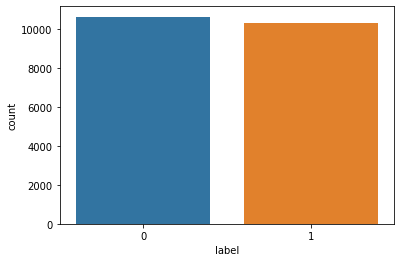

In [12]:
import seaborn as sns
%matplotlib inline
print(y.value_counts())
sns.countplot(y,label="Count")

#### Matrice de confusion

Matrice de confusion :


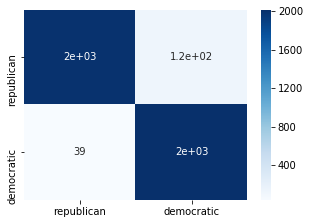

Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2123
           1       0.94      0.98      0.96      2055

    accuracy                           0.96      4178
   macro avg       0.96      0.96      0.96      4178
weighted avg       0.96      0.96      0.96      4178



In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report



print('Matrice de confusion :')
cm = confusion_matrix(test_Y, rs_SVM.predict(test_X))
df = pd.DataFrame(cm, index = ["republican","democratic"], columns = ["republican", "democratic"])
plt.figure(figsize = (5,3.5))
sn.heatmap(df, annot=True, cmap="Blues")
plt.show()

print('Rapport de classification :')
print(classification_report(test_Y, rs_SVM.predict(test_X)))

### Accuracy evaluation 

In [14]:
from sklearn.metrics import accuracy_score
import random
from prettytable import PrettyTable

t = PrettyTable(['Model', 'accuracy test (%)'])
model=['Logistic Regression Classifier','SVM Classifier','Random Forest Classifier','MultinomialNB']
accu=[round(accuracy_score(test_Y,rs_regression_tfidf.predict(test_X))*100,2),round(accuracy_score(test_Y,rs_SVM.predict(test_X))
*100,2),round(accuracy_score(test_Y,rs_rf.predict(test_X))
*100,2),round(accuracy_score(test_Y,rs_MultinomialNB.predict(test_X))
*100,2)]

for i in range(len(accu)):
    
    t.add_row([model[i],accu[i]])

print(t)

+--------------------------------+-------------------+
|             Model              | accuracy test (%) |
+--------------------------------+-------------------+
| Logistic Regression Classifier |       94.93       |
|         SVM Classifier         |       96.07       |
|    Random Forest Classifier    |       95.36       |
|         MultinomialNB          |       95.81       |
+--------------------------------+-------------------+


## Predictions & analyses on election day

In [15]:

db_dir = "./databases/"
features = [['text'], ['id'], ['user','location'], ['user', 'screen_name']]
column_names = ['_'.join(name) for name in features]+['label']

df = pd.DataFrame(columns = column_names)
for filename in os.listdir(db_dir):
    if "election-day" in filename[:-3]:
        elections_day = pd.read_csv(db_dir+filename) 
        elections_day.columns = column_names[:-1]

In [16]:
elections_day.head()

,text,id,user_location,user_screen_name
0,I'm with Purr! Vote Peppah!!! #americafirst #E...,7.959525e+17,"Massachusetts, USA",timeisMEOW2016
1,RT @FNTSYRadio: It's #ElectionDay &amp; no bet...,7.959525e+17,NaN,chachaozone
2,todays the day oh #ElectionDay,7.959525e+17,NaN,goodheartedjc
3,RT @MrScottEddy: All the Places You Can Get Fr...,7.959525e+17,"Hunter Mill, VA",CharlesMcCool
4,RT @PerlinNikki: Go vote. Stay true to yoursel...,7.959525e+17,"Florida, USA",Mama_Liberal


In [17]:
X = elections_day["text"]
data=list(map(tweet_prep.preprocess, X))
X= pd.Series(data).astype(str).str.zfill(11)

In [18]:
elections_day["predict_party"] = rs_SVM.predict(X)

## Sentiment Analysis per party

### From TP1 

In [19]:
from scipy.sparse import csr_matrix
import math

def bigram(tokens):
    """
    tokens: a list of strings
    """
    bigrams = []
    for words in zip(tokens[:-1],tokens[1:]):
        bigrams.append(" ".join(words))
    # This function returns the list of bigrams
    return bigrams


def trigram(tokens):
    """
    tokens: a list of strings
    """
    trigrams = []
    for words in zip(tokens[:-2],tokens[1:-1], tokens[2:]):
        trigrams.append(" ".join(words))
    # This function returns the list of trigrams
    return trigrams

class TFIDFBoW(object):

    def __init__(self, pipeline, bigram=False, trigram=False):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        words: list of words in the vocabulary
        idf: list of idfs for each document
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.words = None
        self.idf = None
    
    def computeTFIDF(self, tokens):
        """
        Calcule du TF-IDF, à partir d'un dictionnaire de mots et d'une 
        liste de tweets.
        On suppose que l'on a déjà collecté le dictionnaire ainsi que 
        calculé le vecteur contenant l'idf pour chaque document.
        
        Entrée: tokens, une liste de vecteurs contenant les tweets (une liste de liste)
        
        Return: une csr_matrix
        """
        
        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )
            
        word_to_idx = {word:idx for idx,word in enumerate(self.words)}
        
        tf = np.zeros((len(tokens), len(self.words)),dtype=np.int8)
        
        for tweet_idx,tweet_tokens in enumerate(tokens):
            all_tokens = tweet_tokens.copy()
            if self.bigram == True :
                all_tokens+=bigram(tweet_tokens)
            if self.bigram == True :
                all_tokens+=trigram(tweet_tokens)
                
            for token in all_tokens:
                word_idx = word_to_idx.get(token, -1)
                if word_idx>=0:
                    tf[tweet_idx,word_to_idx[token]] += 1

        # puisque ce n'est pas specifié on utilise le np.log
        if self.idf is None:
            self.idf = np.log(tf.shape[0] / (tf!=0).sum(axis=0))
        
        return np.multiply(tf, self.idf)


    def fit_transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs de flottants avec la pondération TF-IDF.
        
        Entrée : X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """
        toknized_tweets = list(map(self.pipeline.preprocess, X))
        words_dictionnary = set()
        for tweet in toknized_tweets:
            for token in tweet:
                words_dictionnary.add(token)
            if self.bigram == True :
                for token in bigram(tweet):
                    words_dictionnary.add(token)
            if self.trigram == True :
                for token in trigram(tweet):
                    words_dictionnary.add(token)
                    
        self.words = list(words_dictionnary)
        return self.computeTFIDF(toknized_tweets)
    
    def transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs de flottants avec la pondération TF-IDF.
        Différence avec fit_transform : on suppose qu'on dispose déjà du dictionnaire et du calcul des idf ici.
            
        Entrée : X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """

        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )

        toknized_tweets = list(map(self.pipeline.preprocess, X))
        return self.computeTFIDF(toknized_tweets)
    

In [20]:
from nltk.stem.snowball import SnowballStemmer
import nltk

class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)

    def stem(self, token):
        """
        token: a string that contain a token
        """
        # Have to return the stemmed token
        return list(map(self.stemmer.stem,token))

class NLTKTokenizer(object):
    """
    This tokenizer uses the default function of nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.
    """

    def tokenize(self, text):
        # Have to return a list of tokens
        tokens = nltk.tokenize.word_tokenize(text)
        return tokens

class PreprocessingPipeline:

    def __init__(self, tokenization, twitterPreprocessing, stemming):
        """
        tokenization: enable or disable tokenization.
        twitterPreprocessing: enable or disable twitter preprocessing.
        stemming: enable or disable stemming.
        """

        self.tokenizer = NLTKTokenizer() if tokenization else SpaceTokenizer()
        self.twitterPreprocesser = TwitterPreprocessing(
        ) if twitterPreprocessing else None
        self.stemmer = Stemmer() if stemming else None

    def preprocess(self, tweet):
        """
        Transform the raw data

        tokenization: boolean value.
        twitterPreprocessing: boolean value. Apply the
        stemming: boolean value.
        """
        if self.twitterPreprocesser:
            tweet_processed = self.twitterPreprocesser.preprocess(tweet)
        else:
            tweet_processed = tweet
        
        tokens = self.tokenizer.tokenize(tweet_processed)
        if self.stemmer:
            tokens = self.stemmer.stem(tokens)
        return tokens


In [21]:
import csv
from sklearn.model_selection import train_test_split

def load_dataset(path):
    
    x = []
    y = []

    with open(path, 'r', newline='', encoding="latin-1") as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        
        # Taking the header of the file + the index of useful columns:
        header = next(reader)
        ind_label = header.index('airline_sentiment')
        ind_text = header.index('text')
        
        for row in reader:
            x.append(row[ind_text])
            
            label = row[ind_label]
            
            if label == "negative":
                y.append(0)
            elif label == "neutral":
                y.append(1)
            elif label == "positive":
                y.append(2)

        assert len(x) == len(y)

        return x, y


# Path of the dataset
path = "data/airline_tweets_database.csv"

X_tp1, y_tp1 = load_dataset(path)


In [22]:
from sklearn.linear_model import LogisticRegression
# init configuration
selected_conf = {"model":TFIDFBoW, "tokenize":True, "stemming": True, "preprocess":True, "bi":True}

stemming = selected_conf.get("stemming",False)
tw_prep = selected_conf.get("preprocess",False)
tokenize = selected_conf.get("tokenize",False)
bi = selected_conf.get("bi",False)
tri = selected_conf.get("tri",False)

# init preprocessing pipeline
pipeline = PreprocessingPipeline(tokenization = tokenize, twitterPreprocessing = tw_prep, stemming = stemming)
bowObj = selected_conf["model"](pipeline, bigram = bi, trigram = tri)

training_rep = bowObj.fit_transform(X_tp1)

# fit the classifier
classifier = LogisticRegression(n_jobs=-1)
classifier.fit(training_rep, y_tp1)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
elections_rep = bowObj.transform(elections_day.text.values)

In [25]:
elections_day.head()

,text,id,user_location,user_screen_name,predict_party
0,I'm with Purr! Vote Peppah!!! #americafirst #E...,7.959525e+17,"Massachusetts, USA",timeisMEOW2016,1
1,RT @FNTSYRadio: It's #ElectionDay &amp; no bet...,7.959525e+17,NaN,chachaozone,0
2,todays the day oh #ElectionDay,7.959525e+17,NaN,goodheartedjc,0
3,RT @MrScottEddy: All the Places You Can Get Fr...,7.959525e+17,"Hunter Mill, VA",CharlesMcCool,1
4,RT @PerlinNikki: Go vote. Stay true to yoursel...,7.959525e+17,"Florida, USA",Mama_Liberal,1


In [26]:
elections_day["sentiment"] = classifier.predict_proba(elections_rep)[:,1]

In [28]:
#drop nan
elections_day = elections_day.dropna()

In [ ]:
from geotext import GeoText
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)
def get_state(x):
    cities = GeoText(x).cities
    if len(cities)==0:
        return "UNK"
    else:
        results = search.by_city(cities[0])
        state = results[0].state if len(results) else "UNK"
        return state

elections_day["normalized_loc"] = elections_day.user_location.apply(get_state,1)

In [94]:
dataframe.columns

Index(['0', '1'], dtype='object')

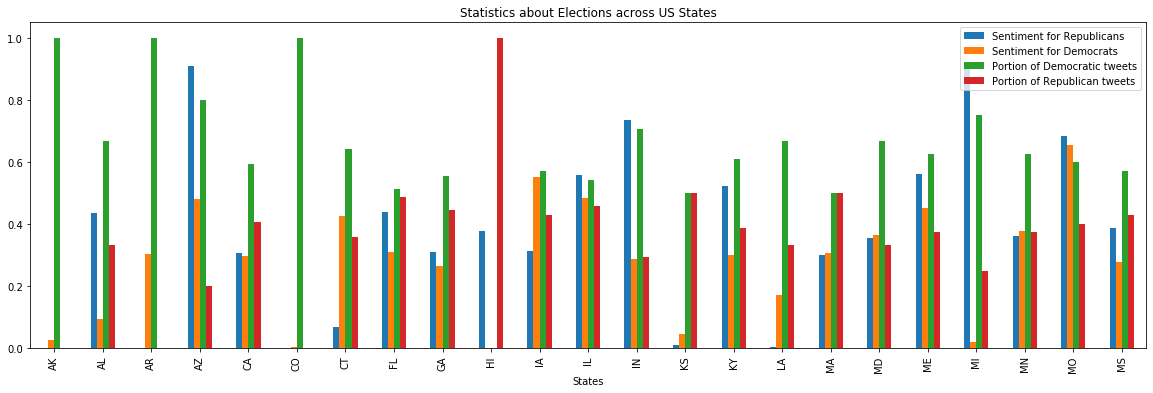

In [119]:
dataframe = pd.DataFrame(pd.pivot_table(elections_day, values="sentiment",columns="predict_party", aggfunc=np.nanmean,index="normalized_loc").to_records()).set_index("normalized_loc")
dataframe = dataframe.merge(elections_day.groupby("normalized_loc")["predict_party"].mean().to_frame(),right_index=True, left_index=True)
dataframe.columns = ["Sentiment for Republicans", "Sentiment for Democrats", "Portion of Democratic tweets"]
dataframe["Portion of Republican tweets"] = 1 - dataframe["Portion of Democratic tweets"]

dataframe.iloc[:23].plot.bar(figsize=(20,6))
plt.title("Statistics about Elections across US States")
plt.xlabel("States");

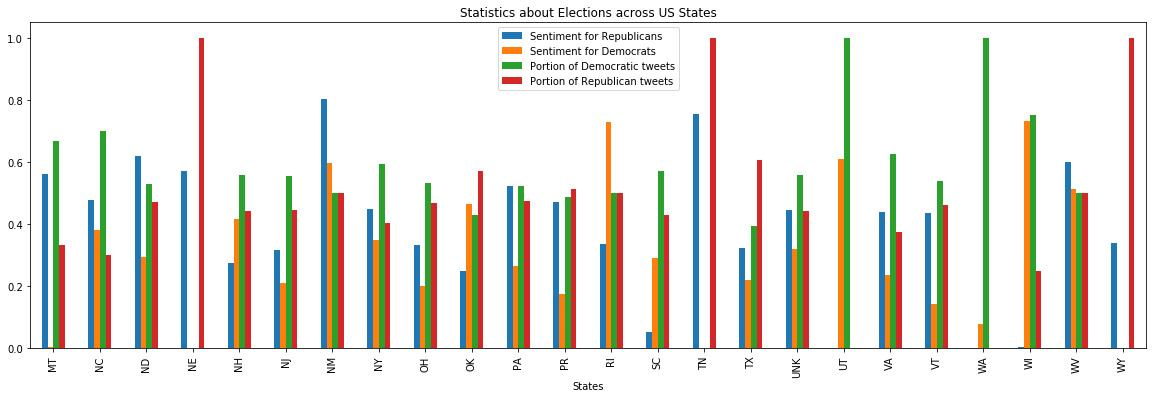

In [118]:
dataframe.iloc[23:].plot.bar(figsize=(20,6))
plt.title("Statistics about Elections across US States")
plt.xlabel("States");